# Topic Modeling of news articles from UFC's official website 

In [125]:
import pandas as pd
import gensim as gs
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark', {'axes.grid' : False})

## Analysis configs

We pick bigram model since UFC events can be centered around a fighter, and the names are most likely two words

In [18]:
df = pd.read_csv('../../datasets/ufc_trends.csv')

In [19]:
df.head()

,categories,title,body,tags
0,['Athletes'],SERGHEI SPIVAC IS ALL FOCUS,year old polar bear moldova dropped two first ...,[]
1,"[""Dana White's Contender Series""]",Week 4 Preview | Dana White's Contender Series...,last week marked first episode season four fig...,['card preview']
2,['Fight Coverage'],Fight by Fight Preview | UFC Fight Night: Gane...,similar last september french heavyweight ciry...,"['UFC Paris', 'Ciryl Gane', 'Serghei Spivac', ..."
3,['Results'],Road To UFC Final Results & Scorecards | Seaso...,went sunday morning watch ufc fight pas watch ...,"['Road To UFC', 'results', 'scorecards']"
4,['Road To UFC'],Updates To Road To UFC Season 2,haraguchi fight jae hyun park tomorrow road uf...,['Road To UFC']


In [20]:
text_data = list(df.body.to_numpy())

In [33]:
# tokenize
tokens = [gs.utils.simple_preprocess(t) for t in text_data]

In [59]:
# bigram model
bigram = gs.models.Phrases(tokens, min_count=5, threshold=25) # higher min_count & threshold -> less phrases
bigram_model = gs.models.phrases.Phraser(bigram)
print(bigram, bigram_model)

# make bigrams for each doc
bigrams = [bigram_model[doc] for doc in tokens]
bigrams[2][:15]


Phrases<75249 vocab, min_count=5, threshold=25, max_vocab_size=40000000> FrozenPhrases<869 phrases, min_count=5, threshold=25>


['similar',
 'last',
 'september',
 'french',
 'heavyweight',
 'ciryl_gane',
 'competes',
 'main_event',
 'facing',
 'surging',
 'contender',
 'serghei_spivac',
 'fight',
 'immediate',
 'impact']

## Latent Dirichlet Allocation

In [79]:
# create dictionary & corpus for LDA model in gensim

id2word = gs.corpora.Dictionary(bigrams)
print(id2word)
corpus = [id2word.doc2bow(text) for text in bigrams] # word id & count in each doc

[(id2word[id], freq) for id, freq in corpus[0][:12]]

Dictionary<8709 unique tokens: ['ability', 'accor_arena', 'achievement', 'address', 'adesanya_strickland']...>


[('ability', 1),
 ('accor_arena', 1),
 ('achievement', 1),
 ('address', 1),
 ('adesanya_strickland', 1),
 ('adjustment', 1),
 ('adopted', 1),
 ('affect', 1),
 ('ahead', 1),
 ('almost', 1),
 ('also', 3),
 ('although', 1)]

In [109]:
# finding best lda model by varying the number of topics

models_by_topics = dict()
topics_range = range(5, 26)
best_model_by_topic = None
best_coherence_score = 0

for tn in topics_range:
  lda_model = gs.models.ldamodel.LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=tn,
    random_state=33,
    update_every=1,
    chunksize=40,
    passes=15,
    alpha='auto',
    per_word_topics=True
  )
  # compute coherence score
  coherence_model_lda = gs.models.CoherenceModel(model=lda_model, texts=bigrams, dictionary=id2word, coherence='c_v')
  coherence_score = coherence_model_lda.get_coherence()
  if coherence_score > best_coherence_score:
    best_coherence_score = coherence_score
    best_model_by_topic = lda_model
  models_by_topics[tn] = dict({
    'model': lda_model,
    'coherence_score': coherence_score
  })

print(f'Best model: {best_model_by_topic.num_topics} topics with coherence score of {best_coherence_score}')

Best model: 7 topics with coherence score of 0.5283401228279863


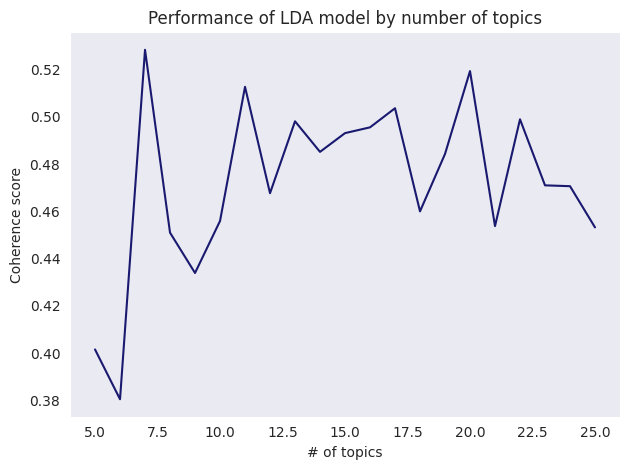

In [111]:
# visualize performance by number of topics

sns.lineplot(x=topics_range, y=[x['coherence_score'] for x in models_by_topics.values()], color="midnightblue")
plt.title(label='Performance of LDA model by number of topics')
plt.xlabel(xlabel='# of topics')
plt.ylabel(ylabel='Coherence score')
plt.tight_layout()
plt.show()

In [152]:
topic_terms = dict()
top_n = 10
for n in range(best_model_by_topic.num_topics):
  topic_terms[n] = dict()
  for id, prob in best_model_by_topic.get_topic_terms(topicid=n, topn=top_n):
    topic_terms[n][id2word[id]] = prob
topic_terms[3]

{'ufc': 0.06611778,
 'bout': 0.018462297,
 'fight': 0.015537776,
 'event': 0.010760545,
 'poirier': 0.0095088435,
 'pas': 0.009275884,
 'fighting': 0.007944396,
 'dustin_poirier': 0.0070500798,
 'justin_gaethje': 0.006552598,
 'kevin_holland': 0.006227062}

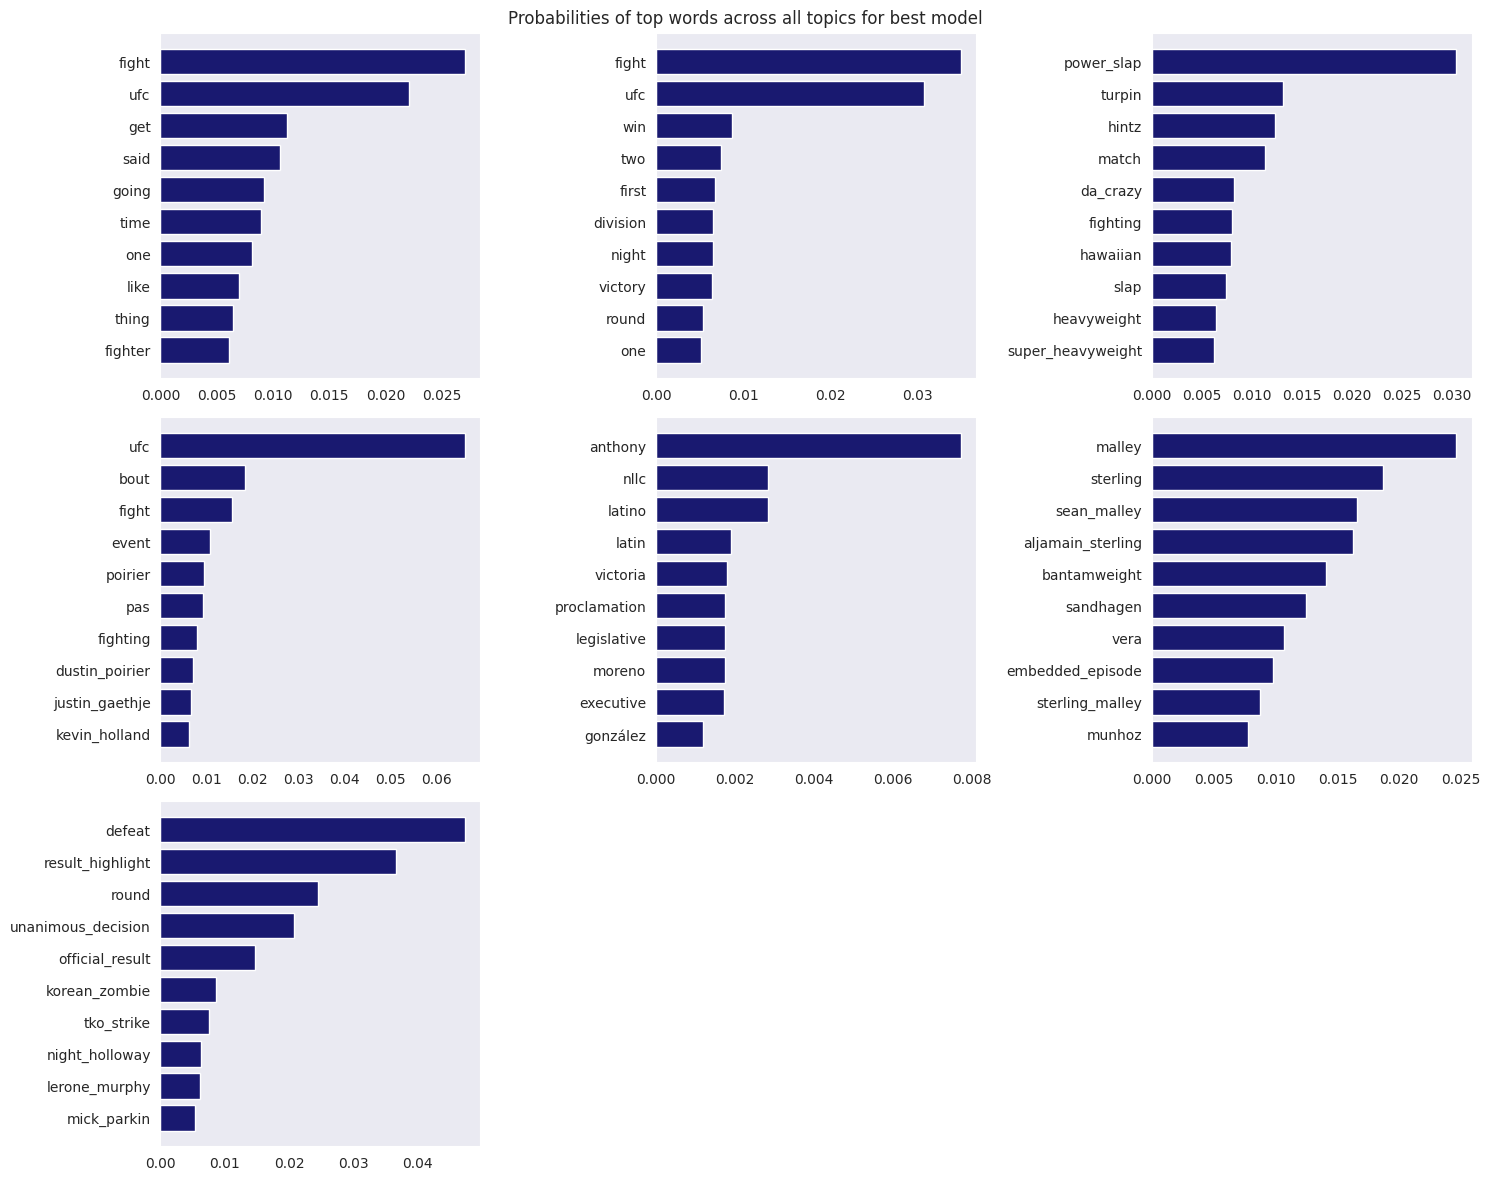

In [172]:
# visualize all topics and their important terms

cols = 3
rows = best_model_by_topic.num_topics//cols + 1
fig, axs = plt.subplots(rows, cols, figsize=(cols*5, rows*4))

for a in range(best_model_by_topic.num_topics):
  axs[a//cols, a%cols].barh(y=np.arange(top_n), width=list(topic_terms[a].values()), color='midnightblue' )
  axs[a//cols, a%cols].set_yticks(np.arange(top_n))
  axs[a//cols, a%cols].set_yticklabels(labels=list(topic_terms[a].keys()))
  axs[a//cols, a%cols].invert_yaxis()
# turn off extra axes
for b in range(best_model_by_topic.num_topics, rows*cols):
  axs[b//cols, b%cols].set_axis_off()

fig.suptitle('Probabilities of top words across all topics for best model')
plt.tight_layout()
plt.show()

## Inferences

In [168]:
# get dominant topic for each document

# topic contributions across each document
doc_topic_cons = best_model_by_topic.get_document_topics(bow=corpus)
doc_topic_cons = [sorted(cons, key=lambda x:x[1], reverse=True) for cons in doc_topic_cons]

In [169]:
doc_topic_cons[:6]

[[(0, 0.5752777), (1, 0.42442855)],
 [(1, 0.9786343), (0, 0.020961152)],
 [(1, 0.6369394), (3, 0.22760415), (0, 0.13540092)],
 [(1, 0.57953584), (6, 0.30442253), (0, 0.11577143)],
 [(0, 0.49582878), (6, 0.31960857), (1, 0.16801202), (3, 0.011196892)],
 [(6, 0.41230008), (3, 0.3706281), (1, 0.21222894)]]

In [171]:
# tabulate dominant topics and contributions for each doc

topics_n_cons = dict({
  'Topic': [vals[0][0] for vals in doc_topic_cons],
  'Contribution': [vals[0][1] for vals in doc_topic_cons]
})
df1 = pd.DataFrame.from_dict(topics_n_cons)
df1['text'] = df['body'].copy()

# looking at the several documents of the same topic we can further identify what a particular topic is about
df1.head()


,Topic,Contribution,text
0,0,0.575278,year old polar bear moldova dropped two first ...
1,1,0.978634,last week marked first episode season four fig...
2,1,0.636939,similar last september french heavyweight ciry...
3,1,0.579536,went sunday morning watch ufc fight pas watch ...
4,0,0.495829,haraguchi fight jae hyun park tomorrow road uf...


In [178]:
df.loc[47, 'title']

'UFC 292 Embedded | All Episodes'

In [180]:
topic_terms[5]

{'malley': 0.02462713,
 'sterling': 0.018727748,
 'sean_malley': 0.016585145,
 'aljamain_sterling': 0.01630025,
 'bantamweight': 0.014095344,
 'sandhagen': 0.012495374,
 'vera': 0.010653899,
 'embedded_episode': 0.009765708,
 'sterling_malley': 0.00871526,
 'munhoz': 0.0077570467}